In [1]:
import sys
print(sys.version)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [7]:
# Importing dependencies
import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.random.set_seed(42)
tensorflow.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import GRU
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [8]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [9]:
import pandas as pd
df = pd.read_csv("/content/DataSet-Final.csv")
df.tail()

,text,label
4978,শালী একটা মাগী অতিবিশিষ্ট দের ছুদা দেয়,Gender abusive hate
4979,সালিরে কঠিন সাজা দেওয়া হোক,Gender abusive hate
4980,ওই খানকিরে সব ছাএ ভাইয়েরা মিলা ছুদেন তাই নাকি ...,Gender abusive hate
4981,নায়িকা ফেল তরে এক রাত চুতে পারলে অনেক বাল লাগত,Gender abusive hate
4982,শ্রাবনী শায়ালাকে চুদবো ওর মা কে কুকুর দিয়ে চুদাবো,Gender abusive hate


In [14]:
# Correlation matrix
df.corr()

""


In [15]:
print(df.describe().label) 
df.drop(df[df['label']==0].index, inplace = True) #Dropping rows with volume value 0

count             4983
unique              14
top       Geopolitical
freq              1379
Name: label, dtype: object


In [16]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [17]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse,rmse, r2, Y_test, Y_hat
  

In [18]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("hate speech using Multivariate-GRU")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [19]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

In [20]:
# Extracting the series
series = df[['text','label']] # Picking the features
print(series.shape)
print(series.tail())

(4983, 2)
                                                   text                label
4978           শালী একটা মাগী অতিবিশিষ্ট  দের ছুদা দেয়   Gender abusive hate
4979                         সালিরে কঠিন সাজা দেওয়া হোক  Gender abusive hate
4980  ওই খানকিরে সব ছাএ ভাইয়েরা মিলা ছুদেন তাই নাকি ...  Gender abusive hate
4981     নায়িকা ফেল তরে এক রাত চুতে পারলে অনেক বাল লাগত  Gender abusive hate
4982  শ্রাবনী শায়ালাকে চুদবো ওর মা কে কুকুর দিয়ে চুদাবো  Gender abusive hate


In [26]:
# Train Val Test Split
train_data_start = df.label(1,1)
train_data_end = df.label(12,31)
train_data = series.loc[train_data_start:train_data_end]

val_start = df.label(1,1)
val_end = df.label(12,31)
val_data = series.loc[val_start:val_end]

test_start = df.label(1,1)
test_end = df.label(12,31)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

TypeError: ignored

In [27]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

In [30]:
model,train_error,val_error = fit_model(timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

TypeError: ignored

In [25]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

NameError: ignored

In [32]:
pip install bnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bnlp: filename=bnlp-0.8-py3-none-any.whl size=32826 sha256=718110c8868b4ea67ec31ae5bf29967779610c6836668afa58d2df11bbece922
  Stored in directory: /root/.cache/pip/wheels/09/e4/f9/548b582bf7e2e2aa4a6ad8f73e53c82aada38289954781004e
Successfully built bnlp


In [34]:
pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 13.5 MB/s 
     |████████████████████████████████| 23.9 MB 85.7 MB/s 
     |████████████████████████████████| 965 kB 45.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [35]:
import string 
import seaborn as sns
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import io
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from bnlp.corpus.util import remove_stopwords

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [36]:
rstate = 10

In [37]:
df = pd.read_csv("/content/DataSet-Final.csv")
df.sample(frac=1)

,text,label
4595,"ভারত যেন বাংলাদেশের কোনো ব্যাপারে নাক না গলা, ...",Geopoitical Hate
2977,পাকির দালল গুলারে জুতা মারা উচিত,Geopolitical
4356,হেরেছে গণমানুষের চাওয়া জিতেছে হাসিনা এটা একটি...,Political Normal
1375,সালের যুদ্ধে বাংলাদেশ থেকে যেই শরনার্থী শিবির ...,Geopolitical
372,দেশটা রাজাকারে ভরতি হয়ে গেল রে আফসোস,Political
...,...,...
2895,ওর দুধ আর পাচা দেখেত আমার সোনা খারা হয়ে গেছে ...,Gender abusive
2763,সনিকা তুমি চুদা খেতে পাড় আমরা বল্লে ধুস,Personal
905,পাকিস্তান একটা আতঙ্ক বাদি দেশ ও সব দেশেই আতঙ্ক...,Geopolitical
3980,সাজু হালারে কেও ধইরা (তেরে নাম) এর পাগলা গারদ ...,Personal Hate


In [38]:
df.rename(columns = {'text':'texts'}, inplace = True)
df.sample(frac=1)

,texts,label
190,শূন্যের আবিষ্কার ও একজন মালাউনের আয়ুর্বেদ এই...,Religious
3523,কুত্তার হোল,Personal Hate
838,শালিরে কচুদেও ভোদায়,Gender abusive
4125,ওটা নাকি দেশ নায়ক লন্ডনে বসে সালা চুর,Political Hate
1643,কানকির পোলারা ৭১ জন্য এখন পর্যন্ত ক্ষমা চায়নি,Geopolitical
...,...,...
4024,এটা হচ্ছে মাহির এবং সরকারের আরেকটা চাইল ।,Political Hate
1398,মাহিরে চুদার সময় আছে বাঙালির,Political
3083,রোহিংগার জাত লাথি মারেন তাই না সালে ভারত যদি ...,Geopolitical
4739,পাকিস্তান কে ঘৃনা করি,Geopoitical Hate


In [39]:
df['label'].value_counts()

Geopolitical           1379
Personal                629
Political               592
Personal Hate           531
Religious               502
Gender abusive          316
Political Hate          200
Political Normal        200
Religious Hate          200
Geopoitical Hate        200
Gender abusive hate     200
Gender Abusive           30
Abusive                   3
Political                 1
Name: label, dtype: int64

In [40]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [42]:
def remove_punctuation(txt):
    txt_nopunct = "".join([c for c in txt if c not in string.punctuation])
    return txt_nopunct

In [44]:
df['msg_clean'] = df['texts'].apply(lambda x:remove_punctuation(x))
df.head()

,texts,label,msg_clean
0,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...,Geopolitical,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...
1,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে,Geopolitical,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে
2,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...,Religious,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...
3,আমরা বলতে কারা ভারত তাইতো,Geopolitical,আমরা বলতে কারা ভারত তাইতো
4,পাকিস্তান আমার বাল,Geopolitical,পাকিস্তান আমার বাল


In [45]:
basic_tokenizer = BasicTokenizer()
df['tokenized'] = df['msg_clean'].apply(lambda x: basic_tokenizer.tokenize(x))

In [46]:
df.head()

,texts,label,msg_clean,tokenized
0,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...,Geopolitical,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...,"[ইনিই, হচ্ছেন, ভারতের, প্রতিরক্ষামন্ত্রী, মনো..."
1,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে,Geopolitical,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে,"[রেন্ডিয়াকে, পৃথীবির, মানচিএ, থেকে, মুচে, ফেলত..."
2,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...,Religious,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...,"[এই, মালাউনরা, বাংগালিদের, সাফল্য, দেখে, হিংসা..."
3,আমরা বলতে কারা ভারত তাইতো,Geopolitical,আমরা বলতে কারা ভারত তাইতো,"[আমরা, বলতে, কারা, ভারত, তাইতো]"
4,পাকিস্তান আমার বাল,Geopolitical,পাকিস্তান আমার বাল,"[পাকিস্তান, আমার, বাল]"


In [47]:
df['Removed Stopped word'] = df['msg_clean'].apply(lambda x: remove_stopwords(x,stopwords))
df.head()

,texts,label,msg_clean,tokenized,Removed Stopped word
0,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...,Geopolitical,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...,"[ইনিই, হচ্ছেন, ভারতের, প্রতিরক্ষামন্ত্রী, মনো...","[ইনিই, হচ্ছেন, ভারতের, প্রতিরক্ষামন্ত্রী, মনো..."
1,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে,Geopolitical,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে,"[রেন্ডিয়াকে, পৃথীবির, মানচিএ, থেকে, মুচে, ফেলত...","[রেন্ডিয়াকে, পৃথীবির, মানচিএ, মুচে, ফেলতে]"
2,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...,Religious,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...,"[এই, মালাউনরা, বাংগালিদের, সাফল্য, দেখে, হিংসা...","[মালাউনরা, বাংগালিদের, সাফল্য, হিংসা, বাহির, দ..."
3,আমরা বলতে কারা ভারত তাইতো,Geopolitical,আমরা বলতে কারা ভারত তাইতো,"[আমরা, বলতে, কারা, ভারত, তাইতো]","[কারা, ভারত, তাইতো]"
4,পাকিস্তান আমার বাল,Geopolitical,পাকিস্তান আমার বাল,"[পাকিস্তান, আমার, বাল]","[পাকিস্তান, বাল]"


In [48]:
df['texts']=df['Removed Stopped word'].apply(' '.join)

In [49]:
X=df['texts']
y=df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=rstate)

In [50]:
cv = CountVectorizer(stop_words = stopwords)
cv.fit(X)

# transform the training and testing data using count vectorizer object
X_train_count =  cv.transform(X_train)
X_test_count =  cv.transform(X_test)

tfidf_tr = TfidfTransformer()
X_train_count_tfidf = tfidf_tr.fit_transform(X_train_count)
X_test_count_tfidf = tfidf_tr.transform(X_test_count)

# ngram level tf-idf 
tv_ngram = TfidfVectorizer(ngram_range=(1,2))
tv_ngram.fit(X)
X_train_tfidf_ngram =  tv_ngram.transform(X_train)
X_test_tfidf_ngram =  tv_ngram.transform(X_test)

In [51]:
X_train_count.shape

(3488, 2040)

In [52]:
X_test_count.shape

(1495, 2040)

In [53]:
def classifierModel(classifier, Xtrain, Ytrain, Xtest,roc):
    classifier.fit(Xtrain, Ytrain)
    predictions = classifier.predict(Xtest)
    print(30*'=')
    print("Accuracy : ", accuracy_score(predictions, y_test))
    print(30*'=')
    if roc:
        probs = classifier.predict_proba(X_test_count_tfidf)
        preds = probs[:,1]
        fpr_svm, tpr_svm, threshold_svm = metrics.roc_curve(y_test, preds)
        roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)

        import matplotlib.pyplot as plt
        plt.title(type(classifier).__name__)
        plt.plot(fpr_svm, tpr_svm, 'b', label = 'AUC = %0.2f' % roc_auc_svm)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    
    target_names = ['class 0', 'class 1']
    print(classification_report(y_test, predictions, target_names=target_names))

In [54]:
print("\nLinearSVM with Count Vectors: ")
classifierModel(SVC(kernel='linear', probability=True), X_train_count, y_train, X_test_count,roc=True)

print("\nLinearSVM with Count Vectors + TF-IDF: ")
classifierModel(SVC(kernel='linear', probability=True), X_train_count_tfidf, y_train, X_test_count_tfidf,roc=True)

print("\nLinearSVM with N-Gram Vectors: ")
classifierModel(SVC(kernel='linear', probability=True), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram,roc=False)


LinearSVM with Count Vectors: 
Accuracy :  0.38996655518394646


ValueError: ignored

In [55]:
print("\nNaive Bayes with Count Vectors: ")
classifierModel(MultinomialNB(), X_train_count, y_train, X_test_count,roc=True)

print("\nNaive Bayes with Count Vectors + TF-IDF: ")
classifierModel(MultinomialNB(), X_train_count_tfidf, y_train, X_test_count_tfidf,roc=True)

print("\nNaive Bayes with N-Gram Vectors: ")
classifierModel(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram,roc=False)


Naive Bayes with Count Vectors: 
Accuracy :  0.3732441471571906


ValueError: ignored

In [56]:
print("\nRandom Forrest Classifier with Count Vectors: ")
classifierModel(RandomForestClassifier(random_state=rstate,n_estimators=512), X_train_count, y_train, X_test_count,roc=True)

print("\nRandom Forrest Classifier with Count Vectors + TF-IDF: ")
classifierModel(RandomForestClassifier(random_state=rstate,n_estimators=512), X_train_count_tfidf, y_train, X_test_count_tfidf,roc=True)

print("\nRandom Forrest Classifier with N-Gram Vectors: ")
classifierModel(RandomForestClassifier(random_state=rstate,n_estimators=512), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram,roc=False)


Random Forrest Classifier with Count Vectors: 
Accuracy :  0.3826086956521739


ValueError: ignored

In [57]:
print("\nLogistic Regression with Count Vectors: ")
classifierModel(LogisticRegression(), X_train_count, y_train, X_test_count,roc=True)

print("\nLogistic Regression with Count Vectors + TF-IDF: ")
classifierModel(LogisticRegression(), X_train_count_tfidf, y_train, X_test_count_tfidf,roc=True)

print("\nLogistic Regression with N-Gram Vectors: ")
classifierModel(LogisticRegression(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram,roc=False)


Logistic Regression with Count Vectors: 
Accuracy :  0.4100334448160535


ValueError: ignored

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [59]:
Models = ['LinearSVM','MultinomialNB', 'RandomForest', 'LogisticRegression']

lsvm_acc = [0.922,0.944,0.977]
mnb_acc = [0.933,0.922,0.933]
rf_acc = [0.944,0.955,0.966]
lr_acc = [0.966,0.955,0.966]

lsvm_pre = [0.922,0.944,0.98]
mnb_pre = [0.933,0.922,0.94]
rf_pre = [0.944,0.96,0.97]
lr_pre = [0.97,0.96,0.97]

lsvm_re = [0.922,0.944,0.98]
mnb_re = [0.933,0.922,0.94]
rf_re = [0.944,0.96,0.97]
lr_re = [0.97,0.96,0.97]

lsvm_f1 = [0.922,0.944,0.98]
mnb_f1 = [0.933,0.922,0.93]
rf_f1 = [0.944,0.96,0.97]
lr_f1 = [0.97,0.96,0.97]


print("Average Accuracy:==============")
print("Average LSVM: ",round(statistics.mean(lsvm_acc), 3))
print("Average MNB: ",round(statistics.mean(mnb_acc), 3))
print("Average RF: ",round(statistics.mean(rf_acc), 3))
print("Average LR: ",round(statistics.mean(lr_acc), 3))


print("Average Precision:==============")
print("Average LSVM: ",round(statistics.mean(lsvm_pre), 3))
print("Average MNB: ",round(statistics.mean(mnb_pre), 3))
print("Average RF: ",round(statistics.mean(rf_pre), 3))
print("Average LR: ",round(statistics.mean(lr_pre), 3))


print("Average Recall:==============")
print("Average LSVM: ",round(statistics.mean(lsvm_re), 3))
print("Average MNB: ",round(statistics.mean(mnb_re), 3))
print("Average RF: ",round(statistics.mean(rf_re), 3))
print("Average LR: ",round(statistics.mean(lr_re), 3))


print("Average F1-score:==============")
print("Average LSVM: ",round(statistics.mean(lsvm_f1), 3))
print("Average MNB: ",round(statistics.mean(mnb_f1), 3))
print("Average RF: ",round(statistics.mean(rf_f1), 3))
print("Average LR: ",round(statistics.mean(lr_f1), 3))

Average Accuracy:==============
Average LSVM:  0.948
Average MNB:  0.929
Average RF:  0.955
Average LR:  0.962
Average Precision:==============
Average LSVM:  0.949
Average MNB:  0.932
Average RF:  0.958
Average LR:  0.967
Average Recall:==============
Average LSVM:  0.949
Average MNB:  0.932
Average RF:  0.958
Average LR:  0.967
Average F1-score:==============
Average LSVM:  0.949
Average MNB:  0.928
Average RF:  0.958
Average LR:  0.967


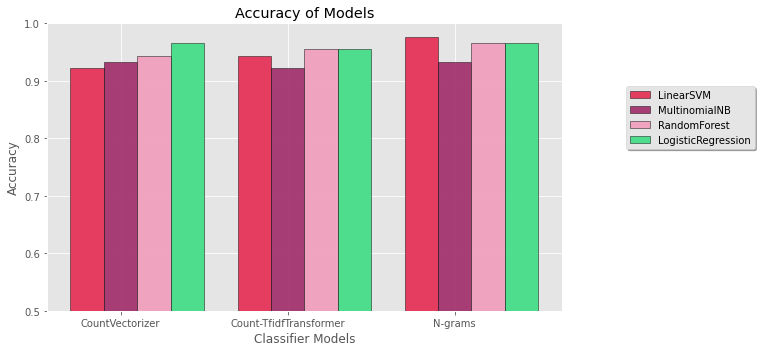

In [60]:
n_groups = 3

fig, ax = plt.subplots(figsize=(8,5))

index = np.arange(n_groups)
bar_width = 0.2

opacity = 0.9
error_config = {'ecolor': '0.3'}



rects1 = ax.bar(index, lsvm_acc, bar_width,
                alpha=opacity, color='#E52B50', error_kw=error_config,edgecolor='black',
                label=Models[0])

rects2 = ax.bar(index + bar_width, mnb_acc, bar_width,
                alpha=opacity, color='#9F2B68',edgecolor='black',
                error_kw=error_config,
                label=Models[1])

rects3 = ax.bar(index + (bar_width*2), rf_acc, bar_width,edgecolor='black',
                alpha=opacity, color='#F19CBB',
                error_kw=error_config,
                label=Models[2])

rects4 = ax.bar(index + (bar_width*3), lr_acc, bar_width,edgecolor='black',
                alpha=opacity, color='#3DDC84',
                error_kw=error_config,
                label=Models[3])

ax.set_xlabel('Classifier Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Models')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(('CountVectorizer', 'Count-TfidfTransformer', 'N-grams'))
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.25, 0.8), shadow=True, ncol=1)
plt.ylim(0.5, 1.0)
fig.tight_layout()
plt.show()


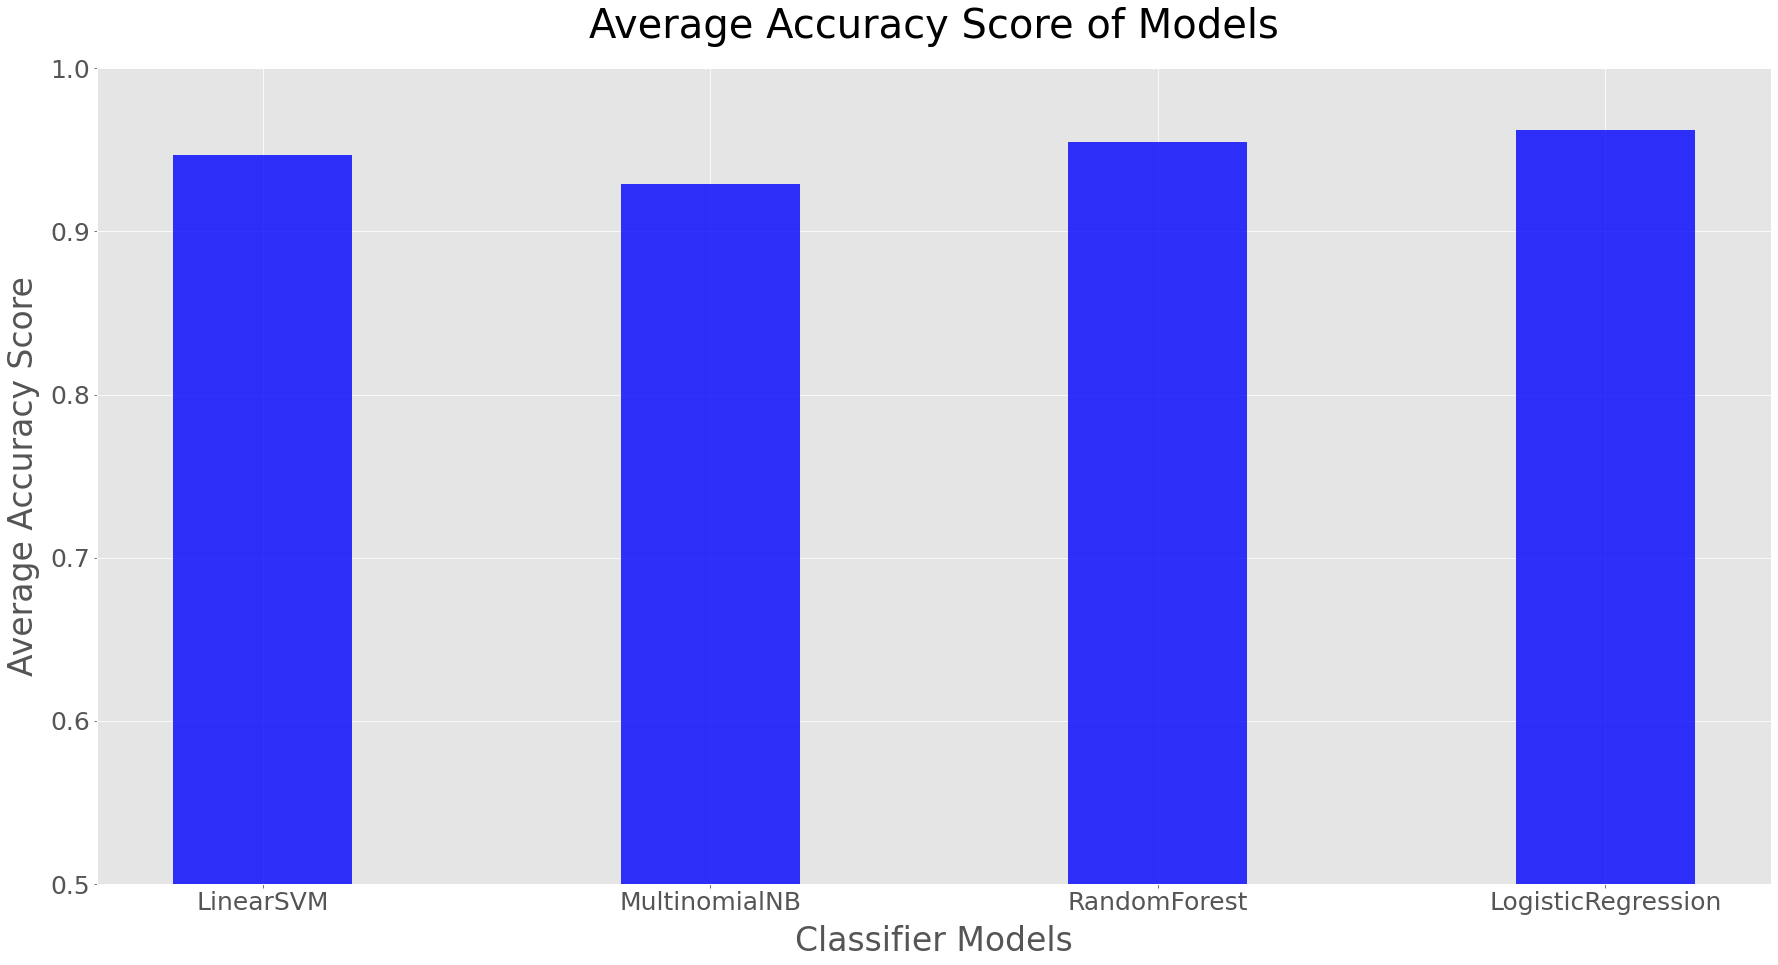

In [61]:
#Average Accuracy
Models = ['LinearSVM','MultinomialNB', 'RandomForest', 'LogisticRegression']
Values = [0.947,0.929,0.955,0.962]

n_groups = 4

fig, ax = plt.subplots(figsize=(30,15))

index = np.arange(n_groups)
bar_width = 0.4

opacity = 0.8
error_config = {'ecolor': '0.3'}

fts1 = ax.bar(index, Values, bar_width,
                alpha=opacity, color='b', error_kw=error_config)

ax.set_xlabel('Classifier Models', fontsize = 33, labelpad=10)
ax.set_ylabel('Average Accuracy Score', fontsize = 33, labelpad=10)
ax.set_title('Average Accuracy Score of Models', fontsize = 40, y = 1.03)
ax.set_xticks(index)
ax.set_xticklabels((Models[0], Models[1], Models[2], Models[3]), fontsize = 25)
ax.set_yticklabels(('0.5','0.6','0.7','0.8','0.9','1.0'),fontsize=25)

plt.ylim(0.5, 1.0)

plt.show()
fig.savefig("pimage6.png",bbox_inches='tight')

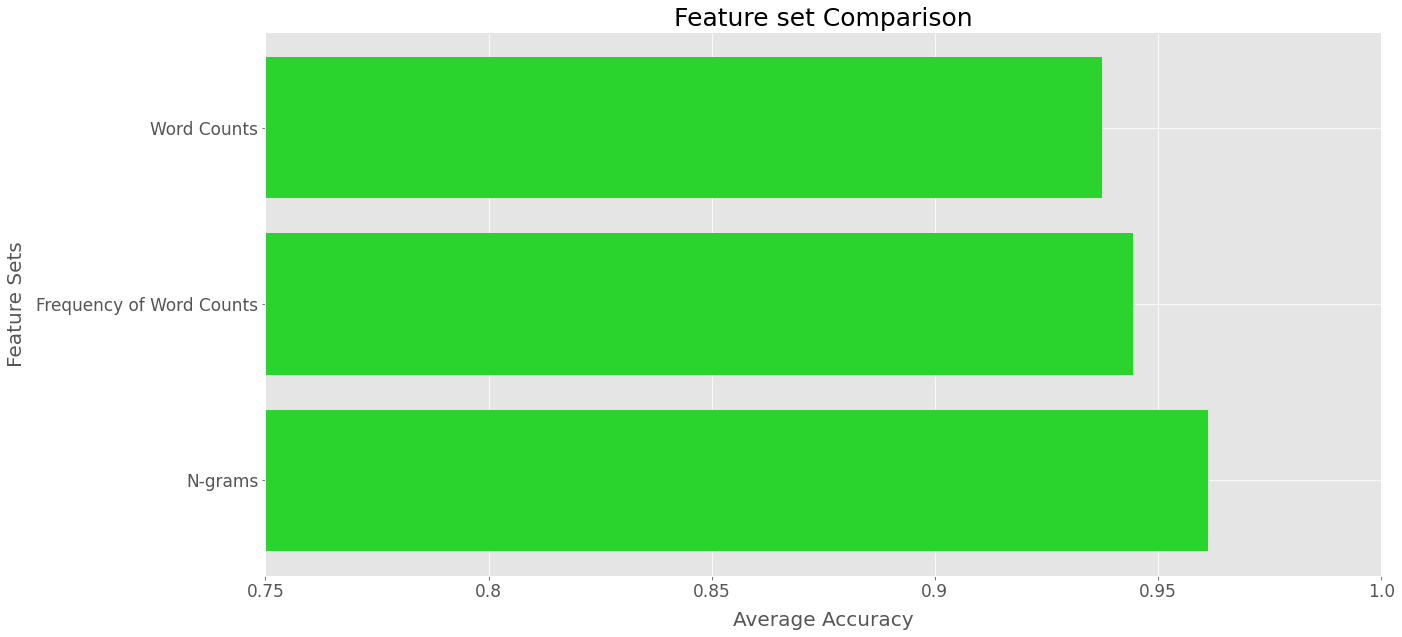

In [63]:
#compare feature sets for two labels
fig, ax = plt.subplots(figsize=(20,10))

features = ('Word Counts', 'Frequency of Word Counts', 'N-grams')
values= [0.9375,0.9444,0.9611]

y_pos = np.arange(len(features))

ax.barh(y_pos, values, align='center',color='#2BD32D', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(features,fontsize=17)
ax.set_xticklabels(('0.75','0.8','0.85','0.9','0.95','1.0'),fontsize=17)
ax.invert_yaxis() 
ax.set_xlabel('Average Accuracy', labelpad=10, fontsize=20)
ax.set_ylabel('Feature Sets', labelpad=10, fontsize=20)
ax.set_title('Feature set Comparison', fontsize=25)
plt.xlim(0.75, 1.0)

plt.show()

fig.savefig("pimage16.png",bbox_inches='tight')

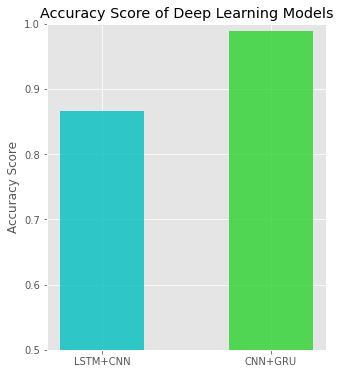

In [64]:
Models = ['LSTM+CNN','CNN+GRU']
Values = [0.8667,0.9889]

n_groups = 2

fig, ax = plt.subplots(figsize=(5,6))

index = np.arange(n_groups)
bar_width = 0.5

opacity = 0.8
error_config = {'ecolor': '0.2'}
width=1.0,

fts1 = ax.bar(index, Values, bar_width,
                alpha=opacity, color=['c','#2BD32D'], error_kw=error_config)

#ax.set_xlabel('Classifier', fontsize = 33, labelpad=5)
ax.set_ylabel('Accuracy Score')
ax.set_title('Accuracy Score of Deep Learning Models')
ax.set_xticks(index)
ax.set_xticklabels((Models[0], Models[1]))
ax.set_yticklabels(('0.5','0.6','0.7','0.8','0.9','1.0'))

plt.ylim(0.5, 1.0)

plt.show()